# 03 - Model Development

**Purpose**: Train and compare multiple machine learning models for flat price prediction.

**Models**: Random Forest, XGBoost, Neural Network

**Evaluation**: RMSE, MAE, R² on validation set

## 1. Import Libraries and Load Processed Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Machine Learning models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Deep Learning
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)

# Suppress tensorflow warnings for cleaner output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Load preprocessed data from previous notebook
X_train = np.load('../data/processed/X_train.npy')
X_val = np.load('../data/processed/X_val.npy')
y_train = np.load('../data/processed/y_train.npy')
y_val = np.load('../data/processed/y_val.npy')

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (80000, 20)
Validation set: (20000, 20)


## 2. Define Evaluation Function

In [3]:
# Standard regression metrics for model comparison
# RMSE: Root Mean Squared Error (penalizes large errors)
# MAE: Mean Absolute Error (average prediction error)
# R²: Coefficient of determination (proportion of variance explained)

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE: {mae:,.2f}")
    print(f"R²: {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

## 3. Model 1: Random Forest Regressor

In [4]:
# Random Forest: Ensemble of decision trees
# Bootstrap aggregation reduces overfitting and variance
# Handles non-linear relationships and feature interactions naturally
# n_estimators: number of trees in the forest
# max_depth: maximum depth of each tree (prevents overfitting)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Predict on validation set
rf_pred = rf_model.predict(X_val)

# Evaluate performance
rf_results = evaluate_model(y_val, rf_pred, "Random Forest")

Training Random Forest...

Random Forest Performance:
RMSE: 313,898.38
MAE: 235,557.98
R²: 0.9970


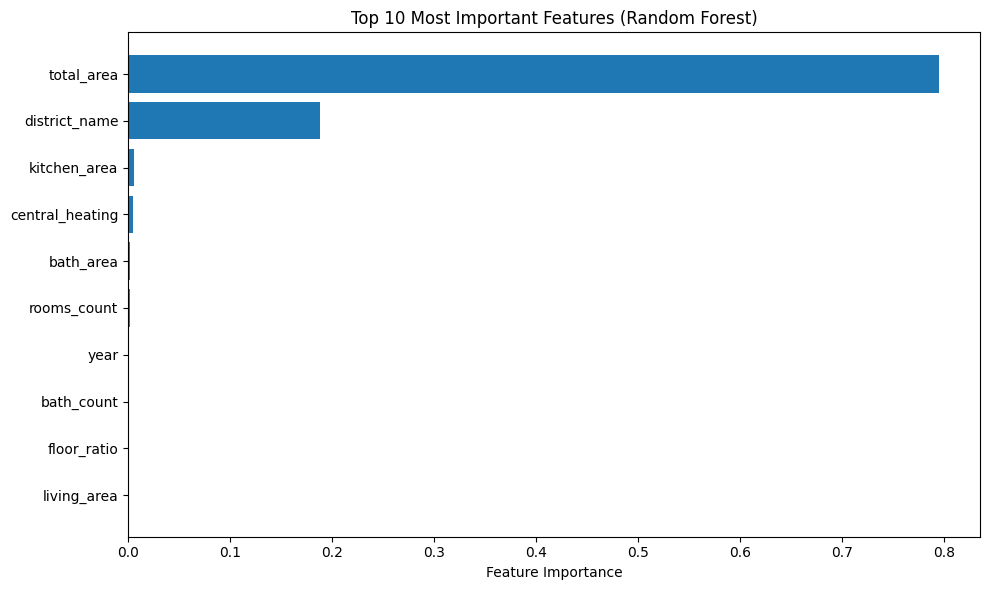

In [5]:
# Feature importance from Random Forest
# Shows which features contribute most to predictions
feature_names = open('../data/processed/feature_names.txt').read().split('\n')
importances = rf_model.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1][:10]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices])
plt.yticks(range(10), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Model 2: XGBoost Regressor

In [6]:
# XGBoost: Gradient boosting optimized for speed and performance
# Sequential ensemble: each tree corrects errors of previous trees
# State-of-the-art for structured/tabular data
# learning_rate: step size for weight updates (lower = more conservative)
# max_depth: depth of trees (controls model complexity)

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

# Predict on validation set
xgb_pred = xgb_model.predict(X_val)

# Evaluate performance
xgb_results = evaluate_model(y_val, xgb_pred, "XGBoost")

Training XGBoost...

XGBoost Performance:
RMSE: 179,695.82
MAE: 145,000.47
R²: 0.9990


## 5. Model 3: Neural Network (Multi-Layer Perceptron)

In [7]:
# Neural Network architecture for tabular regression
# Funnel design (128→64→32): progressively compress feature representations
# ReLU activation: addresses vanishing gradient problem
# Linear output: appropriate for continuous prediction

input_dim = X_train.shape[1]

nn_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    
    # First hidden layer: extract high-level feature patterns
    layers.Dense(128, activation='relu'),
    
    # Second hidden layer: learn feature combinations
    layers.Dense(64, activation='relu'),
    
    # Third hidden layer: refine representations
    layers.Dense(32, activation='relu'),
    
    # Output layer: single neuron for price prediction
    layers.Dense(1)
])

# Model summary
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile model with optimizer and loss function
# Adam optimizer: adaptive learning rate for efficient training
# MSE loss: mean squared error, standard for regression

nn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Early stopping prevents overfitting
# Monitors validation loss and stops if no improvement
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Wait 20 epochs for improvement
    restore_best_weights=True,  # Use best model, not last
    verbose=1
)

In [ ]:
# Train neural network
# batch_size=32: number of samples per gradient update
# epochs=100: maximum training iterations
# validation_data: used for early stopping

print("Training Neural Network...")
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict on validation set
nn_pred = nn_model.predict(X_val, verbose=0).flatten()

# Evaluate performance
nn_results = evaluate_model(y_val, nn_pred, "Neural Network")

Training Neural Network...
Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 418us/step - loss: 128253150887936.0000 - mae: 9241978.0000 - val_loss: 14421591064576.0000 - val_mae: 3031810.7500
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 10099025248256.0000 - mae: 2566650.7500 - val_loss: 8187285078016.0000 - val_mae: 2370368.5000
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step - loss: 7823463284736.0000 - mae: 2344628.7500 - val_loss: 7414459400192.0000 - val_mae: 2292335.7500
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - loss: 7308986286080.0000 - mae: 2307843.7500 - val_loss: 7098104545280.0000 - val_mae: 2297017.2500
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - loss: 7077387304960.0000 - mae: 2294424.2500 - val_loss: 6916956225536.0000 - val_mae: 2273603.0000
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 6935092396032.0000 - mae: 2286833.5000 - val_loss: 6820620926976.0000 - val_mae: 2255643.7500
Epoch 7/100
250

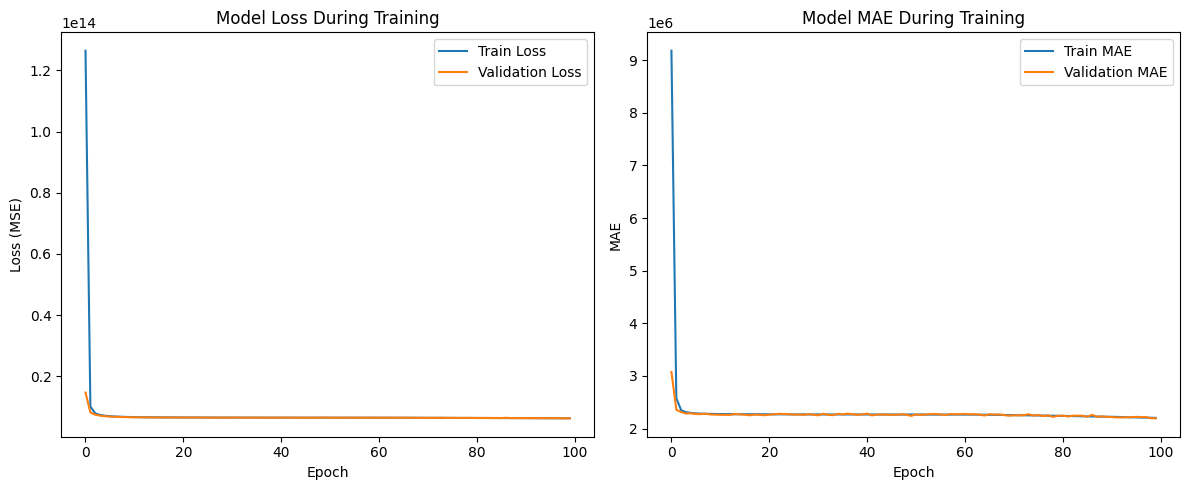

In [ ]:
# Plot training history
# Loss curves show learning progress and detect overfitting
# Gap between train and val loss indicates overfitting

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model MAE During Training')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Model Comparison

In [ ]:
# Compare all models on validation set
# Lower RMSE/MAE and higher R² indicate better performance

results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Neural Network'],
    'RMSE': [rf_results['RMSE'], xgb_results['RMSE'], nn_results['RMSE']],
    'MAE': [rf_results['MAE'], xgb_results['MAE'], nn_results['MAE']],
    'R²': [rf_results['R2'], xgb_results['R2'], nn_results['R2']]
})

print("\n" + "="*60)
print("MODEL COMPARISON ON VALIDATION SET")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


MODEL COMPARISON ON VALIDATION SET
           Model         RMSE          MAE       R²
Ridge Regression 2.535490e+06 2.268771e+06 0.803350
   Random Forest 3.138984e+05 2.355580e+05 0.996986
         XGBoost 1.796958e+05 1.450005e+05 0.999012
  Neural Network 2.495097e+06 2.193914e+06 0.809565


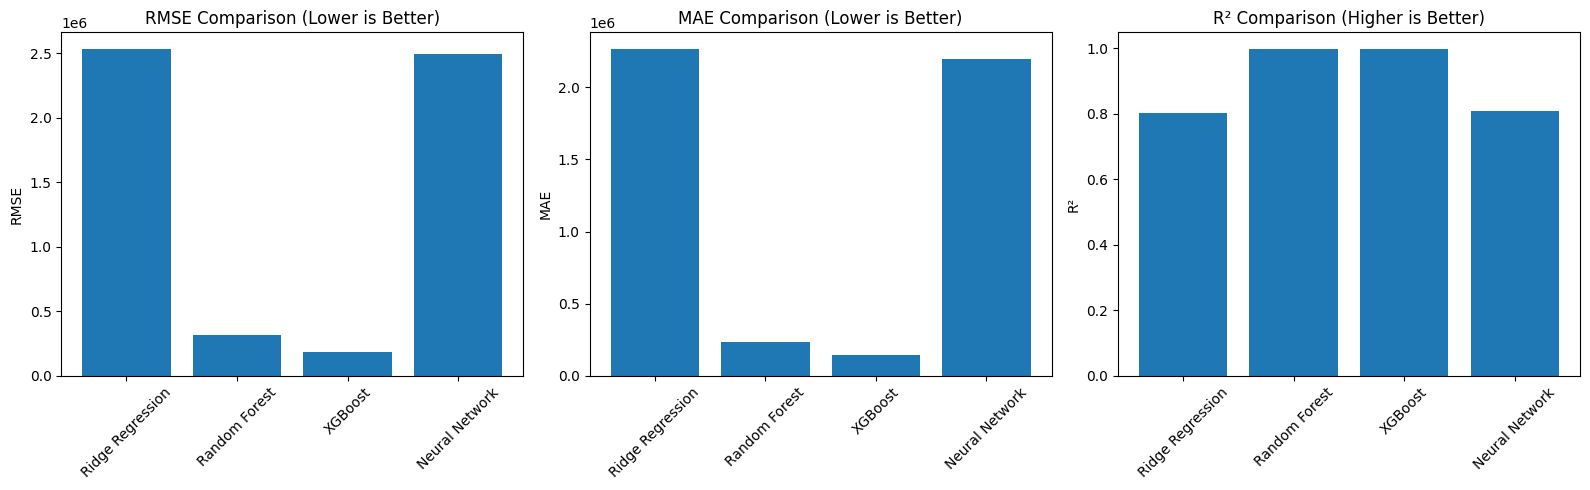

In [ ]:
# Visualize model comparison
# Bar charts make it easy to identify best performing model

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE comparison (lower is better)
axes[0].bar(results_df['Model'], results_df['RMSE'])
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison (lower is better)
axes[1].bar(results_df['Model'], results_df['MAE'])
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Comparison (Lower is Better)')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison (higher is better)
axes[2].bar(results_df['Model'], results_df['R²'])
axes[2].set_ylabel('R²')
axes[2].set_title('R² Comparison (Higher is Better)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Save Best Models

In [ ]:
# Save all trained models for later use
# joblib for sklearn/xgboost models (efficient serialization)
# Keras .save() for neural network

joblib.dump(rf_model, '../models/random_forest.pkl')
joblib.dump(xgb_model, '../models/xgboost.pkl')
nn_model.save('../models/neural_network.keras')

print("Models saved successfully!")
print("\nSaved models:")
print("- ../models/random_forest.pkl")
print("- ../models/xgboost.pkl")
print("- ../models/neural_network.keras")

Models saved successfully!

Saved models:
- ../models/linear_regression.pkl (Ridge)
- ../models/random_forest.pkl
- ../models/xgboost.pkl
- ../models/neural_network.keras


In [ ]:
# Identify and save best model name
# Best model has lowest RMSE on validation set
best_model_idx = results_df['RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']

with open('../models/best_model.txt', 'w') as f:
    f.write(best_model_name)

print(f"\nBest performing model: {best_model_name}")
print(f"Validation RMSE: {results_df.loc[best_model_idx, 'RMSE']:,.2f}")


Best performing model: XGBoost
Validation RMSE: 179,695.82
